In [1]:
import pandas as pd
import numpy as np
import re
import string
import ssl

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


2026-02-03 17:09:29.337866: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 17:09:29.339921: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 17:09:29.380969: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 17:09:29.382004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 17:09:30.218605: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")   
nltk.download("omw-1.4")   


[nltk_data] Downloading package stopwords to /home/tamara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tamara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tamara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tamara/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
token = RegexpTokenizer(r"[a-zA-Z0-9]+")

In [4]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)       
    text = re.sub(r"https?://\S+", "", text) 
    text = re.sub(r"\d+", "", text)          
    text = text.translate(str.maketrans("", "", string.punctuation))  

    tokens = token.tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in STOPWORDS]
    return " ".join(tokens)


In [5]:
data = pd.read_csv("data/IMDB Dataset.csv")
data.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
data["target"] = data["sentiment"].apply(lambda s: 1 if s == "positive" else 0)
data["cleaned_review"] = data["review"].apply(clean_text)

data = data.drop_duplicates()
data = data[["cleaned_review", "target"]]

data.head()


,cleaned_review,target
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1


In [7]:
X_text = data["cleaned_review"].astype(str).values
y = data["target"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=0.1, random_state=42, stratify=y_train
)


In [8]:
MAX_VOCAB = 20000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

X_train = pad_sequences(
    tokenizer.texts_to_sequences(X_train_text),
    maxlen=MAX_LEN, padding="post", truncating="post"
)
X_val = pad_sequences(
    tokenizer.texts_to_sequences(X_val_text),
    maxlen=MAX_LEN, padding="post", truncating="post"
)
X_test = pad_sequences(
    tokenizer.texts_to_sequences(X_test_text),
    maxlen=MAX_LEN, padding="post", truncating="post"
)

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("vocab_size:", vocab_size)


Shapes: (35698, 200) (3967, 200) (9917, 200)
vocab_size: 20000


In [9]:
class MyGRU(layers.Layer):
   
    def __init__(self, units, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.return_sequences = return_sequences

    def build(self, input_shape):
        input_dim = int(input_shape[-1])  # D

        self.Wz = self.add_weight(name="Wz", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Uz = self.add_weight(name="Uz", shape=(self.units, self.units), initializer="orthogonal")
        self.bz = self.add_weight(name="bz", shape=(self.units,), initializer="zeros")

        self.Wr = self.add_weight(name="Wr", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Ur = self.add_weight(name="Ur", shape=(self.units, self.units), initializer="orthogonal")
        self.br = self.add_weight(name="br", shape=(self.units,), initializer="zeros")

        self.Wh = self.add_weight(name="Wh", shape=(input_dim, self.units), initializer="glorot_uniform")
        self.Uh = self.add_weight(name="Uh", shape=(self.units, self.units), initializer="orthogonal")
        self.bh = self.add_weight(name="bh", shape=(self.units,), initializer="zeros")

        super().build(input_shape)

    def call(self, inputs, mask=None, training=None):
        inputs = tf.convert_to_tensor(inputs)
        B = tf.shape(inputs)[0]

        h0 = tf.zeros((B, self.units), dtype=inputs.dtype)

        if mask is not None:
            mask = tf.cast(mask, inputs.dtype)

        x_time = tf.transpose(inputs, perm=[1, 0, 2])  # (T,B,D)
        if mask is not None:
            m_time = tf.transpose(mask, perm=[1, 0])    # (T,B)

        def step(h_prev, x_or_tuple):
            if mask is not None:
                x_t, m_t = x_or_tuple
                m_t = tf.expand_dims(m_t, axis=-1)  # (B,1)
            else:
                x_t = x_or_tuple

            z = tf.sigmoid(tf.matmul(x_t, self.Wz) + tf.matmul(h_prev, self.Uz) + self.bz)
            r = tf.sigmoid(tf.matmul(x_t, self.Wr) + tf.matmul(h_prev, self.Ur) + self.br)

            h_tilde = tf.tanh(tf.matmul(x_t, self.Wh) + tf.matmul(r * h_prev, self.Uh) + self.bh)
            h = (1.0 - z) * h_prev + z * h_tilde

            # na padding pozicijama ne menjaj stanje
            if mask is not None:
                h = m_t * h + (1.0 - m_t) * h_prev

            return h

        elems = (x_time, m_time) if mask is not None else x_time
        h_time = tf.scan(step, elems=elems, initializer=h0)  # (T,B,units)

        if self.return_sequences:
            return tf.transpose(h_time, perm=[1, 0, 2])  # (B,T,units)
        else:
            return h_time[-1]  # (B,units)


In [10]:
EMB_DIM = 128
UNITS = 128
DROPOUT = 0.4
LR = 0.001

inp = layers.Input(shape=(MAX_LEN,), dtype=tf.int32)

x = layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM, mask_zero=True)(inp)
x = MyGRU(UNITS, return_sequences=False)(x)
x = layers.Dropout(DROPOUT)(x)
out = layers.Dense(1, activation="sigmoid")(x)

mygru_model = Model(inp, out)
mygru_model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=LR),
    metrics=["accuracy"]
)

mygru_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 my_gru (MyGRU)              (None, 128)               98688     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2658817 (10.14 MB)
Trainable params: 2658817 (10.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
early2 = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

history_mygru = mygru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early2],
    verbose=1
)


Epoch 1/10
558/558 [==============================] - 87s 153ms/step - loss: 0.3624 - accuracy: 0.8429 - val_loss: 0.3272 - val_accuracy: 0.8719
Epoch 2/10
558/558 [==============================] - 89s 159ms/step - loss: 0.2047 - accuracy: 0.9248 - val_loss: 0.3131 - val_accuracy: 0.8767
Epoch 3/10
558/558 [==============================] - 87s 156ms/step - loss: 0.1248 - accuracy: 0.9572 - val_loss: 0.3487 - val_accuracy: 0.8760
Epoch 4/10
558/558 [==============================] - 87s 155ms/step - loss: 0.0665 - accuracy: 0.9780 - val_loss: 0.4901 - val_accuracy: 0.8601


In [12]:
y_pred_prob = mygru_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"MyGRU Accuracy: {acc*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred))


310/310 [==============================] - 8s 24ms/step
MyGRU Accuracy: 87.98%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      4940
           1       0.90      0.85      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



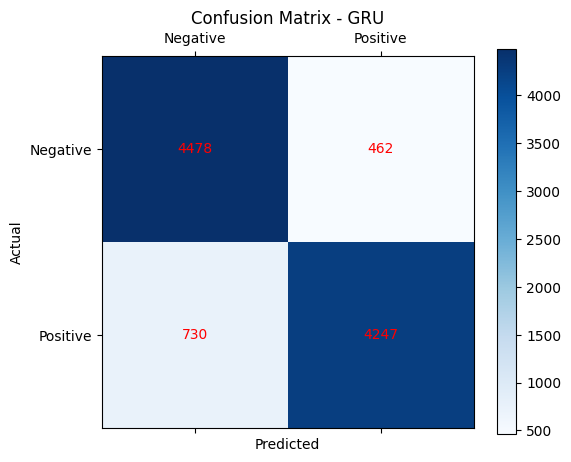

In [13]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)  
plt.title('Confusion Matrix - GRU')
fig.colorbar(cax)

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), va='center', ha='center', color='red')

plt.show()


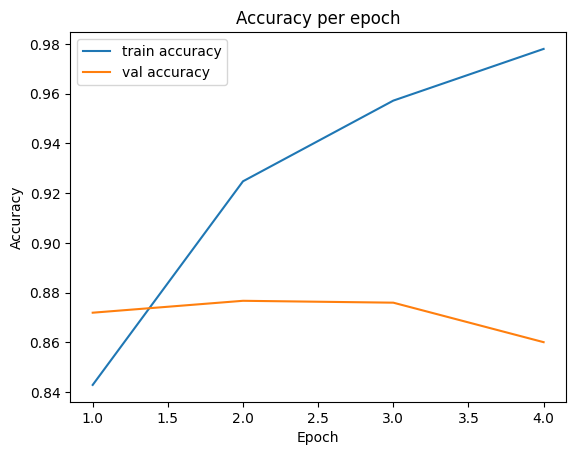

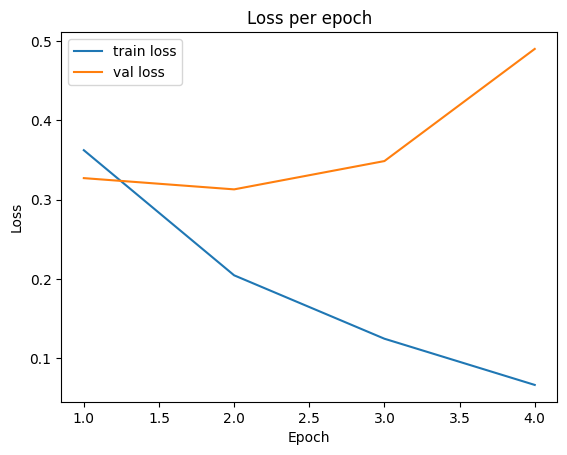

In [14]:
def plot_history(hist):
    acc = hist.history.get('accuracy', [])
    val_acc = hist.history.get('val_accuracy', [])
    loss = hist.history.get('loss', [])
    val_loss = hist.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()

plot_history(history_mygru)


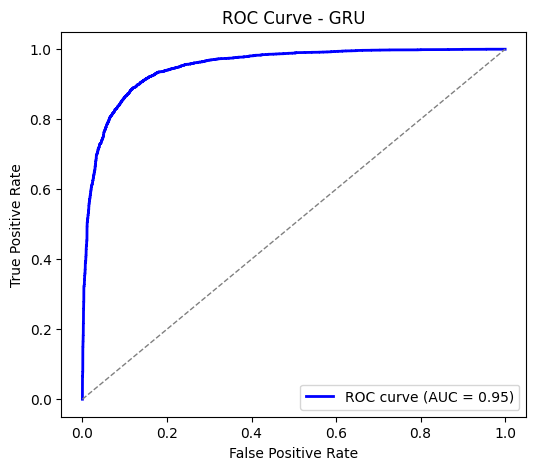

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GRU')
plt.legend(loc='lower right')
plt.show()